In [39]:
"""
Heat equation solver in 
    Spatial: Central Difference
    Temprol: Forward, RK3, Implicit Compact Pade, Crank-Nicolson
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import numpy.linalg


In [40]:
def FTCS(uOrig, dX, dT, alpha):
    uNow = uOrig*1
    uNow[1:-1] = uOrig[1:-1] + alpha*dT/dX**2 * (
        uOrig[2:] - 2*uOrig[1:-1] + uOrig[:-2]
    )
    uNow[[0,-1]] = np.array([0,0])
    return uNow

The Correct RK3 is
$$\begin{aligned}
    u^{(1)} &= u^{n} + \mathcal{L}(u^{n}) \\
    u^{(2)} &= \frac{3}{4}u^{n} + \frac{1}{4}u^{(1)} + \frac{1}{4}\mathcal{L}(u^{\textcolor{red}{(1)}}) \\
    u^{n+1} &= \frac{1}{3}u^{n} + \frac{2}{3}u^{(2)} + \frac{2}{3}\mathcal{L}(u^{\textcolor{red}{(2)}}) \\
\end{aligned}$$

In [41]:
def RK3CS(uOrig, dX, dT, alpha):
    # NOTE: the journal is incorrect please have a look on
    # Proposition 3.2 in TOTAL VARIATION DIMINISHING RUNGE-KUTTA SCHEMES
    uOne = uOrig*np.nan
    uTwo = uOrig*np.nan
    uNow = uOrig*np.nan
    # First Intermediate
    uOne[1:-1] = uOrig[1:-1] + alpha*dT/dX**2 * (
        uOrig[2:] - 2*uOrig[1:-1] + uOrig[:-2]
    )
    uOne[[0,-1]] = np.array([0,0])

    # Second Intermediate
    uTwo[1:-1] = 3./4. * uOrig[1:-1] + 1./4. * uOne[1:-1] + alpha*dT/(4*dX**2) * (
        uOne[2:] - 2*uOne[1:-1] + uOne[:-2]  # if use uOrig Here, the error will go back to FTCS
    )
    uTwo[[0,-1]] = np.array([0,0])

    # Final
    uNow[1:-1] = 1./3. * uOrig[1:-1] + 2./3. * uTwo[1:-1] + 2*alpha*dT/(3*dX**2) * (
        uTwo[2:] - 2*uTwo[1:-1] + uTwo[:-2]  # if use uOrig Here, the error will go back to FTCS
    )
    uNow[[0,-1]] = np.array([0,0])
    return uNow

In [42]:
def CrankNicolsonMatrics(dX, dT, alpha, numP):
    # A*u^(n+1) = B*u^(n)
    A = scipy.sparse.diags([-alpha/(2*dX**2), alpha/dX**2+1/dT,-alpha/(2*dX**2)], [-1,0,1], shape=(numP, numP)).toarray()
    B = scipy.sparse.diags([ alpha/(2*dX**2),-alpha/dX**2+1/dT, alpha/(2*dX**2)], [-1,0,1], shape=(numP, numP)).toarray()
    A[0,0] = 1
    A[0,1] = 0
    A[-1,-1] = 1
    A[-1,-2] = 0
    B[0,0] = 1
    B[0,1] = 0
    B[-1,-1] = 1
    B[-1,-2] = 0
    C = np.linalg.solve(A,B)
    return C

In [43]:
def ImplicitCompactPadeMatrics(dX, dT, alpha, numP):
    # A*u^(n+1) = B*u^(n)
    A = scipy.sparse.diags([-alpha/(2*dX**2) + 1/(12*dT), alpha/dX**2 + 10/(12*dT), -alpha/(2*dX**2) + 1/(12*dT)], [-1,0,1], shape=(numP, numP)).toarray()
    B = scipy.sparse.diags([ alpha/(2*dX**2) + 1/(12*dT),-alpha/dX**2 + 10/(12*dT),  alpha/(2*dX**2) + 1/(12*dT)], [-1,0,1], shape=(numP, numP)).toarray()
    A[0,0] = 1
    A[0,1] = 0
    A[-1,-1] = 1
    A[-1,-2] = 0
    B[0,0] = 1
    B[0,1] = 0
    B[-1,-1] = 1
    B[-1,-2] = 0
    C = np.linalg.solve(A,B)
    return C

In [44]:

# domain -1...1
xMin, xMax = (-1., 1.)
numPoint = 81
xPoints = np.linspace(xMin, xMax, num=numPoint)
deltaX = xPoints[1] - xPoints[0]

# time discretization
tStart = 0.0
tEnd = 1.0
deltaT = 0.0025

# heat conduction coefficient
alpha = 1./np.pi**2

# analytical solution
def AnalyticalHeatEquation(x, t):
    return -np.exp(-t) * np.sin(np.pi * x)


In [45]:
# initial condition
uInitial = AnalyticalHeatEquation(xPoints, tStart)
uOriginal_FT = uInitial * 1.0
uOriginal_RK = uInitial * 1.0
uOriginal_CN = uInitial * 1.0
uOriginal_ICP = uInitial * 1.0
CNMat = CrankNicolsonMatrics(deltaX, deltaT, alpha, numPoint)
ICPMat = ImplicitCompactPadeMatrics(deltaX, deltaT, alpha, numPoint)

tNow = tStart

In [46]:
# iteration
while (tNow < tEnd-deltaT*0.01):
    tNow += deltaT
    uOriginal_FT = FTCS(uOriginal_FT, deltaX, deltaT, alpha)
    uOriginal_RK = RK3CS(uOriginal_RK, deltaX, deltaT, alpha)
    uOriginal_CN = CNMat@uOriginal_CN
    uOriginal_ICP = ICPMat@uOriginal_ICP


Text(0.5, 1.0, 'Error Plot (ICP)')

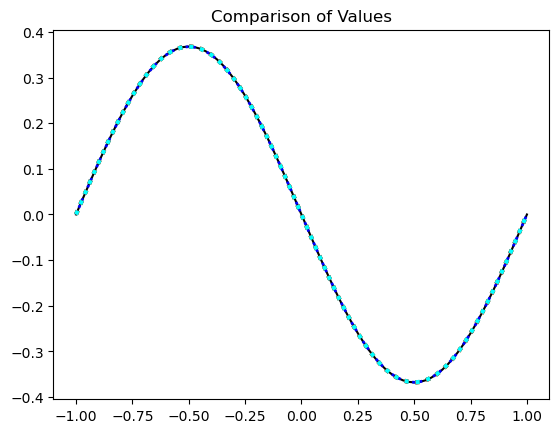

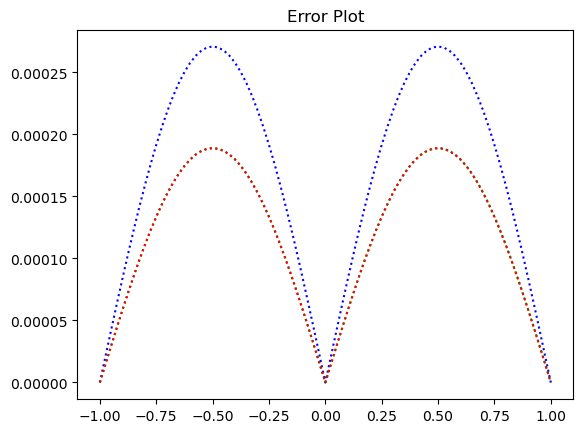

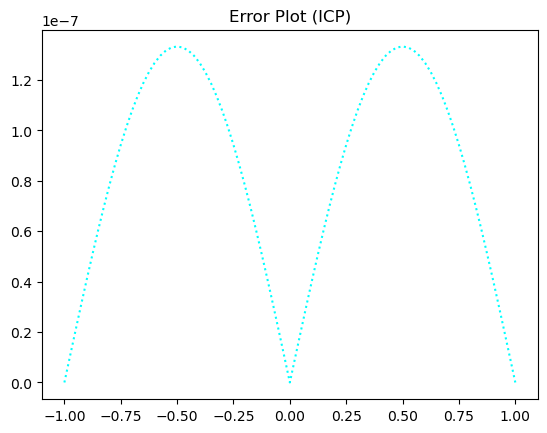

In [48]:

uCurrentAnalytical = AnalyticalHeatEquation(xPoints, tNow)

fig, ax = plt.subplots()
ax.plot(xPoints, uCurrentAnalytical, linestyle="-", color="black")
ax.plot(xPoints, uOriginal_FT, linestyle=":", color="blue", linewidth=2)
ax.plot(xPoints, uOriginal_RK, linestyle=":", color="green", linewidth=3)
ax.plot(xPoints, uOriginal_CN, linestyle=":", color="red", linewidth=3)
ax.plot(xPoints, uOriginal_ICP, linestyle=":", color="cyan", linewidth=3)
ax.set_title("Comparison of Values")


fig, ax = plt.subplots()
ax.plot(xPoints, np.abs(uCurrentAnalytical-uOriginal_FT), linestyle=":", color="blue")
ax.plot(xPoints, np.abs(uCurrentAnalytical-uOriginal_RK), linestyle=":", color="green")
ax.plot(xPoints, np.abs(uCurrentAnalytical-uOriginal_CN), linestyle=":", color="red")
ax.set_title("Error Plot")

fig, ax = plt.subplots()
ax.plot(xPoints, np.abs(uCurrentAnalytical-uOriginal_ICP), linestyle=":", color="cyan")
ax.set_title("Error Plot (ICP)")



